In [11]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

from datasets import datasets
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

alphas = np.logspace(-2.5,-0.5,20)
print(alphas)
Qs = []
Cscore = []
lengths = []

for alpha in alphas:

    seed = 1

    random_state_train_test = seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # desired miscoverage error
    #alpha = 0.01

    # desired quanitile levels
    quantiles = [alpha / 2, 1 - (alpha /2)]

    # used to determine the size of test set
    test_ratio = 0.2

    # number of training examples
    n_train = 2000
    # number of test examples (to evaluate average coverage and length)
    n_test = 5000

    def f(x):
        ''' Construct data (1D example)
        '''
        ax = 0*x
        for i in range(len(x)):
            ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
            ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
        return ax.astype(np.float32)

    # training features
    x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

    # test features
    x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

    # generate labels
    y_train = f(x_train)
    y_test = f(x_test)

    # reshape the features
    x_train = np.reshape(x_train,(n_train,1))
    x_test = np.reshape(x_test,(n_test,1))

    # divide the data into proper training set and calibration set
    idx = np.random.permutation(n_train)
    n_half = int(np.floor(n_train/2))
    idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

    class Net(torch.nn.Module):
        def __init__(self, n_feature):
            super(Net, self).__init__()
            self.net = torch.nn.Sequential(torch.nn.Linear(n_feature, 64),
                                           torch.nn.ReLU(),
                                           #torch.nn.Dropout(0.1),
                                           torch.nn.Linear(64, 64),
                                           torch.nn.ReLU(),
                                           #torch.nn.Dropout(0.1),
                                           torch.nn.Linear(64, 2)
            )
            self.init_weights()

        def init_weights(self):
            for m in self.net:
                if isinstance(m, torch.nn.Linear):
                    torch.nn.init.orthogonal_(m.weight)
                    torch.nn.init.constant_(m.bias, 0)


        def forward(self, x):
            x = self.net(x)             # linear output
            return x

    net = Net(n_feature=1) 
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6)
    def loss_func(y, yhat, alpha):
        return torch.maximum(alpha*(y-yhat),(1-alpha)*(yhat-y))

    tensor_xtrain = torch.Tensor(x_train[idx_train]) # transform to torch tensor
    tensor_ytrain = torch.Tensor(y_train[idx_train])

    train_dataset = TensorDataset(tensor_xtrain,tensor_ytrain) # create your datset
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) # create your dataloader

    tensor_xcal = torch.Tensor(x_train[idx_cal]) # transform to torch tensor
    tensor_ycal = torch.Tensor(y_train[idx_cal])

    cal_dataset = TensorDataset(tensor_xcal,tensor_ycal) # create your datset
    cal_dataloader = DataLoader(cal_dataset, batch_size=400, shuffle=False) # create your dataloader

    tensor_xtest = torch.Tensor(x_test) # transform to torch tensor
    tensor_ytest = torch.Tensor(y_test)

    test_dataset = TensorDataset(tensor_xtest,tensor_ytest) # create your datset
    test_dataloader = DataLoader(test_dataset, batch_size=400, shuffle=False) # create your dataloader

    net.train()
    for t in tqdm(range(1000)):
        itera = iter(train_dataloader)
        for i in range(len(itera)):
            x,y = next(itera)
            prediction = net(x)     # input x and predict based on x

            loss1 = loss_func(y, prediction[:,0], quantiles[0])
            loss2 = loss_func(y, prediction[:,1], quantiles[1])
            loss = (loss1+loss2).mean()

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

    def predict(net, dataloader):
        iteracal = iter(dataloader)
        xs = []
        ys = []
        preds = []
        net.eval()
        for i in range(len(iteracal)):
            x,y = next(iteracal)
            with torch.no_grad():
                prediction = net(x)     # input x and predict based on x

                #loss = loss_func(y, prediction[:,0], quantiles[0])
                #loss = loss_func(y, prediction[:,1], quantiles[1])

                preds.append(prediction.numpy())      # apply gradients
                xs.append(x)
                ys.append(y)
        preds = np.concatenate(preds)
        xs = np.concatenate(xs)
        ys = np.concatenate(ys)
        return xs, ys, preds

    def conformalize(net, cal_dataloader, alpha):
        xs, ys, preds = predict(net, cal_dataloader)
        E = np.maximum(preds[:,0]-ys, ys-preds[:,1])
        E = np.sort(E)
        quantile = (1-alpha)*(1+(1/len(E)))*len(E)
        print("Quantile of E :", quantile)
        quantile = int(np.ceil(quantile))
        print("Quantile of E (ceil):", quantile)
        Q = E[quantile]
        return Q

    def plot_func(x,
                  y,
                  y_u=None,
                  y_l=None,
                  pred=None,
                  shade_color="",
                  method_name="",
                  title="",
                  filename=None,
                  save_figures=False,
                  zoom=True):

        """ Scatter plot of (x,y) points along with the constructed prediction interval 

        Parameters
        ----------
        x : numpy array, corresponding to the feature of each of the n samples
        y : numpy array, target response variable (length n)
        pred : numpy array, the estimated prediction. It may be the conditional mean,
               or low and high conditional quantiles.
        shade_color : string, desired color of the prediciton interval
        method_name : string, name of the method
        title : string, the title of the figure
        filename : sting, name of the file to save the figure
        save_figures : boolean, save the figure (True) or not (False)

        """

        max_show = 1000
        x_ = x[:max_show]
        y_ = y[:max_show]
        if y_u is not None:
            y_u_ = y_u[:max_show]
        if y_l is not None:
            y_l_ = y_l[:max_show]
        if pred is not None:
            pred_ = pred[:max_show]

        fig = plt.figure()
        inds = np.argsort(np.squeeze(x_))
        plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
                 fillstyle='none', label=u'Observations')

        if (y_u is not None) and (y_l is not None):
            plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                     np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                     alpha=.3, fc=shade_color, ec='None',
                     label = method_name + ' prediction interval')

        if pred is not None:
            if pred_.ndim == 2:
                plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                         label=u'Predicted low and high quantiles')
                plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
            else:
                plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                         label=u'Predicted value')

        if zoom:
            plt.ylim([-2.5, 7])
        plt.xlabel('$X$')
        plt.ylabel('$Y$')
        plt.legend(loc='upper right')
        plt.title(title)
        if save_figures and (filename is not None):
            plt.savefig(filename, bbox_inches='tight', dpi=300)

        plt.show()

    xt, yt, predt = predict(net, test_dataloader)
    Q = conformalize(net, cal_dataloader, alpha)
    final_predt = predt + np.array([[-Q, Q]])
    def conformality_score(y, C):
        score = np.logical_and(y>=C[:,0],y<=C[:,1])
        return score.mean()
    
    Cscore.append(conformality_score(yt, final_predt))
    Qs.append(Q)
    lengths.append((final_predt[:,1]-final_predt[:,0]).mean())

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.00316228 0.00402961 0.00513483 0.00654319 0.00833782 0.01062468
 0.01353876 0.01725211 0.02198393 0.02801357 0.03569699 0.04548778
 0.05796394 0.073862   0.0941205  0.11993539 0.15283067 0.1947483
 0.24816289 0.31622777]


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 997.8345600621712
Quantile of E (ceil): 998


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 996.9663590684793
Quantile of E (ceil): 997


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 995.8600322596549
Quantile of E (ceil): 996


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 994.4502676811571
Quantile of E (ceil): 995


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 992.6538399430473
Quantile of E (ceil): 993


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 990.3646970127505
Quantile of E (ceil): 991


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 987.4476994379743
Quantile of E (ceil): 988


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 983.7306423950802
Quantile of E (ceil): 984


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 978.9940895848883
Quantile of E (ceil): 979


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 972.9584188203993
Quantile of E (ceil): 973


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 965.267314543271
Quantile of E (ceil): 966


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 955.466732750492
Quantile of E (ceil): 956


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 942.9780965266164
Quantile of E (ceil): 943


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 927.0641397809856
Quantile of E (ceil): 928


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 906.7853827764665
Quantile of E (ceil): 907


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 880.9446699844556
Quantile of E (ceil): 881


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 848.0164960608572
Quantile of E (ceil): 849


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 806.0569477051336
Quantile of E (ceil): 807


  0%|          | 0/1000 [00:00<?, ?it/s]

Quantile of E : 752.5889448240337
Quantile of E (ceil): 753


100%|██████████| 1000/1000 [00:12<00:00, 80.44it/s]

Quantile of E : 684.456006217145
Quantile of E (ceil): 685


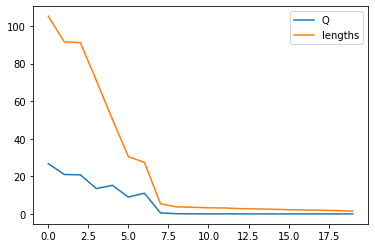

In [12]:
plt.plot(Qs, label="Q")
plt.plot(lengths, label="lengths")
plt.legend()

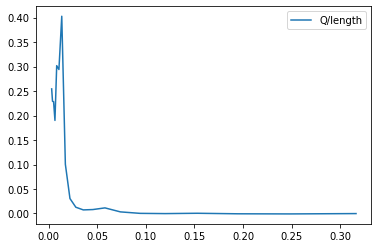

In [19]:
fig = plt.figure()
plt.plot(alphas, list([x/y for x,y in zip(Qs, lengths)]), label="Q/length")
#plt.xscale("log")
plt.legend()

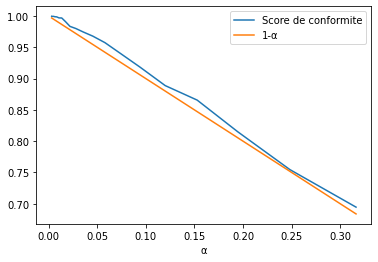

In [31]:
plt.plot(alphas, Cscore, label="Score de conformite")
plt.plot(alphas, 1-alphas, label="1-α")
plt.xlabel("α")
plt.legend()

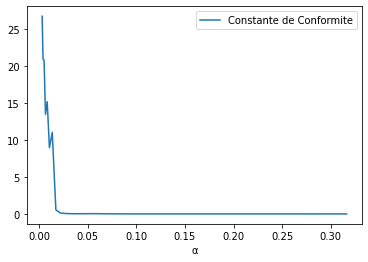

In [35]:
plt.plot(alphas, Qs, label="Constante de Conformite")
plt.xlabel("α")
plt.legend()
#plt.xscale("log")

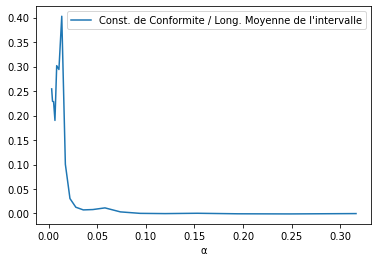

In [37]:
plt.plot(alphas, list([x/y for x,y in zip(Qs, lengths)]), label="Const. de Conformite / Long. Moyenne de l'intervalle")
plt.xlabel("α")
plt.legend()